In [1]:
# -*- coding: utf-8 -*-
"""This module calculates the halo mass functions and is mainly taken from yt.
Three classes:
        halo_mass_function: Calculates dn/dm, and dn /dln sigma
        overdensities: Calculates tables of sigma(M)
        TransferFunction: Eisenstein and Hu transfer function module"""

from __future__ import division
import math
import numpy as np
import scipy.integrate as integ
import scipy.interpolate

class HaloMassFunction(object):
    """Module for calculating halo mass functions. Largely stolen from yt.

    Note self.mass_function(sigma) will return the mass function as defined in eq. 4 of Jenkins 2001.
    Default mass function is Sheth-Tormen.
    Mass function, f(sigma, z) = M / rho_0 (dn / d ln (sigma^-1))
    where rho0(z) is the mean density of the universe at redshift z
    n(M,z) is the abundance of halos with mass less than M at redshift z.

    dndm: returns dn/dm, which is the number of halos per unit mass
    mass_function: returns dn / dln sigma which is what is commonly referred to as the mass function.
    Other functions are various choices of mass function
    """
    def __init__(self, redshift, omega_m=0.32, omega_b=0.045, omega_l=0.68, hubble=0.67, ns=0.96, sigma8=0.83, mass_function=None, log_mass_lim=(1, 20) ,use_pbh=False):
        #Sigma tables
        self.overden = Overdensities(redshift,omega_m, omega_b,omega_l,hubble, ns,sigma8,log_mass_lim=log_mass_lim,use_pbh=use_pbh)
        if mass_function is None:
            self.mass_function = self.tinker_200
        else:
            self.mass_function = mass_function.__get__(self)
        self.delta_c0 = 1.69  # critical density for turnaround (Press-Schechter)

    def dndm(self, mass):
        """Returns the halo mass function dn/dM in units of h^4 M_sun^-1 Mpc^-3
        Requires mass in units of M_sun /h """
        # Mean matter density at redshift z in units of h^2 Msolar/Mpc^3
        # This is the comoving density at redshift z in units of h^-1 M_sun (Mpc/h)^-3 (comoving)
        # Compute as a function of the critical density at z=0.
        rhom = self.overden.rhocrit(0) * self.overden.omega_matter0 #self.overden.omega_matter_of_z(self.overden.redshift)
        sigma = self.overden.sigmaof_M_z(mass)
        mass_func = self.mass_function(sigma)
        dlogsigma = self.overden.log_sigmaof_M(mass)/mass
        #We have dn / dM = - d ln sigma /dM rho_0/M f(sigma)
        dndM = - dlogsigma*mass_func/mass*rhom
        return dndM

    def dndm_z(self, mass, zz):
        """Returns the halo mass function dn/dM in units of h^4 M_sun^-1 Mpc^-3
        Requires mass in units of M_sun /h """
        # Mean matter density at redshift z in units of h^2 Msolar/Mpc^3
        # This is the comoving density at redshift z in units of h^-1 M_sun (Mpc/h)^-3 (comoving)
        # Compute as a function of the critical density at z=0.
        rhom = self.overden.rhocrit(0) * self.overden.omega_matter0 #self.overden.omega_matter_of_z(self.overden.redshift)
        growth = self.overden.Dofz(zz)
        sigma = self.overden.sigmaof_M(mass)*growth
        mass_func = self.mass_function(sigma)
        dlogsigma = self.overden.log_sigmaof_M(mass)/mass
        #We have dn / dM = - d ln sigma /dM rho_0/M f(sigma)
        dndM = - dlogsigma*mass_func/mass*rhom
        return dndM

    def press_schechter(self, sigma):
        """Press-Schechter (This form from Jenkins et al. 2001, MNRAS 321, 372-384, eqtn. 5)"""
        nu = self.delta_c0 / sigma
        return np.sqrt(2.0/np.pi) * nu * np.exp(-0.5*nu*nu)

    def jenkins(self, sigma):
        """Jenkins et al. 2001, MNRAS 321, 372-384, eqtn. 9"""
        return 0.315 * np.exp( -1.0 * np.power( np.abs( np.log(1.0/sigma) + 0.61), 3.8 ) )

    def sheth_tormen(self, sigma):
        """Sheth-Tormen 1999, eqtn 10, using expression from Jenkins et al. 2001, eqtn. 7"""
        nu = self.delta_c0 / sigma
        A=0.3222
        a=0.707
        p=0.3
        return A*np.sqrt(2.0*a/math.pi)*(1.0+ np.power( 1.0/(nu*nu*a), p) )*  nu * np.exp(-0.5*a*nu*nu)

    def warren(self, sigma):
        """LANL fitting function - Warren et al. 2005, astro-ph/0506395, eqtn. 5 """
        A = 0.7234
        a = 1.625
        b = 0.2538
        c = 1.1982
        return A*( np.power(sigma, -1.0*a) + b)*np.exp(-1.0*c / sigma / sigma )

    def tinker_300(self, sigma):
        """Tinker et al. 2008, eqn 3, Delta=300"""
        A = 0.2
        a = 1.52
        b = 2.25
        c = 1.27
        return A * ( np.power((sigma / b), -a) + 1) * np.exp(-1 * c / sigma / sigma)

    def tinker_200(self, sigma):
        """Tinker et al. 2008, eqn 3, Delta=200 # Delta=200"""
        A = 0.186
        a = 1.47
        b = 2.57
        c = 1.19
        return A * ( np.power((sigma / b), -a) + 1) * np.exp(-1 * c / sigma / sigma)

    def tinker_alt(self, sigma):
        """An alternative form of the Tinker mass function that has better asymptotic behaviour.
        Delta = 200."""
        B = 0.482
        d = 1.97
        e = 1.
        f = 0.51
        g = 1.228
        return B*((sigma/e)**(-d)+sigma**(-f))*np.exp(-g/sigma**2)

    def watson_FOF(self, sigma):
        """Watson + 2012, FOF halos linking length = 0.2 * mean"""
        A = 0.282
        a = 2.163
        b = 1.406
        c = 1.210
        return A*( np.power(b / sigma, 1.0*a) + 1)*np.exp(-1.0*c / sigma / sigma )

class Overdensities(object):
    """Module for calculating the linear theory overdensities.
    Main result obtained from sigmaof_M_z"""
    def __init__(self,redshift,omega_m=0.27, omega_b=0.045,omega_l=0.73,hubble=0.67, ns=0.95,sigma8=0.8,num_sigma_bins=10,log_mass_lim=(10, 15), use_pbh=False):
        #Calculate the transfer functions
        #num_sigma_bins = 100 intially
        """
        num_sigma_bins = 10 corresponds to only a 0.055% difference in N_halos
        num_sigma_bins = 5 corresponds to a 55% difference in N_halos
        """
        #log_mass_lim = (1,20)
        self.TF = TransferFunction(omega_m, omega_b, 0.0, 0,omega_l, hubble, redshift)
        self.omega_baryon0 = omega_b
        self.omega_matter0 = omega_m
        self.omega_lambda0 = omega_l
        self.hubble0 = hubble
        self.num_sigma_bins = num_sigma_bins
        self.ns = ns
        self.redshift = redshift
        self.log_mass_max = log_mass_lim[1]
        self.log_mass_min = log_mass_lim[0]

        #Unit scales
        #M_sun in kg
        self.solarmass = 1.98855e30
        #1 Mpc in m
        self.Mpc = 3.086e22
        #Newtons constant in units of (Mpc/h)^3 (Msun/h)^-1 s^-2
        self.gravity = 6.67408e-11/(self.Mpc/self.hubble0)**3 * (self.solarmass/self.hubble0)
        self.use_pbh = use_pbh
        self.Mpbh = 30.*self.hubble0
        #WMAP pivot scale
        self.kpivot = 2e-3
        #Calculate the normalisation of the power spectrum
        self.Norm = 1.
        self.Norm = sigma8*sigma8 / self.sigma_Pk(8.0)
        #Calculate and fill the sigma arrays
        self._sigmaM_init()
        #Set up interpolator
        self.sigma_int=scipy.interpolate.InterpolatedUnivariateSpline(self.logmassarray,self.sigmaarray)
        self.dlog_sigma_int=scipy.interpolate.InterpolatedUnivariateSpline(self.logmassarray,self.dlogsigmaarray)

    def sigmaof_M(self, M):
        """
        Main accessor function to get sigma(M) M in M_sun/h
        """
        return self.sigma_int(np.log10(M))

    def log_sigmaof_M(self, M):
        """
        Get M * d logsigma(M)/dM , with M in M_sun/h
        """
        return self.dlog_sigma_int(np.log10(M))

    def sigmaof_M_z(self, M):
        """
        Main accessor function to get sigma(M) M in M_sun/h
        """
        return self.Dofz(self.redshift)*self.sigma_int(np.log10(M))

    def rhocrit(self, redshift):
        """Critical density at redshift of the snapshot. Units are Msun/Mpc^3 h^2 (comoving)."""
        #scale factor
        aa = 1./(1+redshift)
        #Hubble factor (~70km/s/Mpc) at z=0 in s^-1
        hubble = self.hubble0*3.24077929e-18
        hubz2 = (self.omega_matter0/aa**3 + self.omega_lambda0) * hubble**2
        #Critical density at redshift in units of Msun/Mpc^3 h^2.
        rhocrit = 3 * hubz2 / (8*math.pi* self.gravity)
        return rhocrit

    def _sigmaM_init(self):
        """
         Written by BWO, 2006 (updated 25 January 2007).
         Converted to Python by Stephen Skory December 2009.

         This routine takes in cosmological parameters and creates a file (array) with
         sigma(M) in it, which is necessary for various press-schechter type
         stuff.  In principle one can calculate it ahead of time, but it's far,
         far faster in the long run to calculate your sigma(M) ahead of time.

         Inputs: cosmology, user must set parameters

         Outputs: four columns of data containing the following information:

         1) log mass (Msolar)
         2) mass (Msolar/h)
         3) Radius (comoving Mpc/h)
         4) sigma (normalized) using Msun/h as the input

         The arrays output are used later.
        """
        #Comoving critical density in units of h^2 Msolar/Mpc^3
        rhozero = self.omega_matter0 * self.rhocrit(0)
        # mass in units of h^-1 Msolar
        self.logmassarray = np.linspace(self.log_mass_min, self.log_mass_max, self.num_sigma_bins)
        # radius is in units of h^-1 Mpc (comoving)
        self.Rarray = (3.0*(10**self.logmassarray) / 4.0 / math.pi / rhozero)**(1./3)
        # sigma_squared_of_R to get the sigma(R) (equivalent to sigma(M)); normalization done above.
        self.sigmaarray = np.sqrt(np.array([self.sigma_squared_of_R(R) for R in self.Rarray]))
        #Tabulate M d log sigma/d M
        self.dlogsigmaarray = np.array([self._logsigma_of_R(R) for R in self.Rarray])
        return

    def Mass(self, R):
        """Mass enclosed within radius R in Msolar/h"""
        return 4*math.pi/3 * R**3 * (self.omega_matter0 - self.omega_baryon0) * self.rhocrit(0)

    def sigma_Pk(self, R):
        """
        Calculates sigma^2(R).  This is the routine where the magic happens (or
           whatever it is that we do here).  Integrates the sigma_squared_integrand
           parameter from 0 to infinity.
           Note that R is in h^-1 Mpc (comoving)
        """
        result = integ.quad(self.sigma_squared_integrand,0,np.Inf, args=(R,),epsrel=1e-2)[0]
        return result / (2.0 * math.pi**2)

    def sigma_squared_of_R(self, R):
        """
        Calculates sigma^2(R).  This is the routine where the magic happens (or
           whatever it is that we do here).  Integrates the sigma_squared_integrand
           parameter from 0 to infinity.
           Note that R is in h^-1 Mpc (comoving)
        """
        return self.sigma_Pk(R) #+ self.use_pbh * self.sigma_square_poisson(R)

    def sigma_square_poisson(self, R):
        """Sigma squared from Poisson fluctuations."""
        return self.Mpbh / self.Mass(R)*(self.Dofz(self.redshift)/self.Dofz(3000))**2*1.5**2

    def sigma_squared_integrand(self,k,R):
        """
        integrand for integral to get sigma^2(R).
        Parameters: Rcom is R in comoving Mpc/h
        """
        f = k**2*self.PofK(k)*self.WofK(R*k)**2.0
        return f

    def _logsigma_of_R(self, R):
        """For the halo mass function we also need M * d log sigma/dM.
        This routine computes a table of that quantity.
        We use d log sigma /dM = 1/(2 sigma^2) dR /dM int(k^2 P(k) d/dR(W^2 (kR) dk"""
        result = integ.quad(self.dlogsigma_integrand,0,np.Inf, args=(R,),epsrel=1e-2)[0]
        return result / (2.0 * math.pi**2) * R / (self.sigma_squared_of_R(R) * 3.) #- self.use_pbh*self.sigma_square_poisson(R) / (2*self.sigma_squared_of_R(R))

    def dlogsigma_integrand(self,k,R):
        """
        integrand for integral to get sigma^2(R).
        Parameters: Rcom is R in comoving Mpc/h
        """
        return  k**3*self.PofK(k)*self.WofK(R*k)*self.dWofK(R*k)

    def dWofK(self,x):
        """Returns dW/dx(x), derivative of the fourier transform of the top-hat."""
        #Series expansion actually good until kr~1
        if x < 1e-2:
            return 1./3*(-x/5.+ x**3/70.-x**5/2520) #+O(x^7)
        else:
            return -3. * (np.sin(x) - x*np.cos(x)) / x**4 + np.sin(x)/x**2

    def PofK(self,k):
        """
        Returns power spectrum as a function of wavenumber k
        """
        return self.Norm*k*(k/self.kpivot)**(self.ns-1) * self.TofK(k)**2

    def TofK(self,k):
        """
        Returns transfer function as a function of wavenumber k.
        """
        return self.TF.TFmdm_onek_hmpc(k)

    def WofK(self,x):
        """
        returns W(k*R), which is the fourier transform of the top-hat function.
        """
        #Series expansion actually good until kr~1
        if x < 1e-2:
            return 1./3. - x**2/30. +x**4/840.
        else:
            return (np.sin(x) - x*np.cos(x)) / x**3

    def Dofz(self, redshift):
        """
        /* Growth function */
        """

        thisDofz = self.gofz(redshift) / self.gofz(0.0) / (1.0+redshift)
        return thisDofz


    def gofz(self, redshift):
        """
        /* g(z) - I don't think this has any other name*/
        """

        thisgofz = 2.5 * self.omega_matter_of_z(redshift) / \
        ( math.pow( self.omega_matter_of_z(redshift), 4.0/7.0 ) - \
          self.omega_lambda_of_z(redshift) + \
          ( (1.0 + self.omega_matter_of_z(redshift) / 2.0) * \
          (1.0 + self.omega_lambda_of_z(redshift) / 70.0) ))

        return thisgofz


    def omega_matter_of_z(self,redshift):
        """
        /* Omega matter as a function of redshift */
        """

        thisomofz = self.omega_matter0 * math.pow( 1.0+redshift, 3.0) / \
            math.pow( self.Eofz(redshift), 2.0 )

        return thisomofz

    def omega_lambda_of_z(self,redshift):
        """
        /* Omega lambda as a function of redshift */
        """

        thisolofz = self.omega_lambda0 / math.pow( self.Eofz(redshift), 2.0 )

        return thisolofz

    def Eofz(self, redshift):
        """
        /* E(z) - I don't think this has any other name */
        """
        thiseofz = math.sqrt( self.omega_lambda0 \
            + (1.0 - self.omega_lambda0 - self.omega_matter0)*math.pow( 1.0+redshift, 2.0) \
            + self.omega_matter0 * math.pow( 1.0+redshift, 3.0)  )

        return thiseofz


class TransferFunction(object):
    """
    Fitting Formulae for CDM + Baryon + Massive Neutrino (MDM) cosmologies.
    Daniel J. Eisenstein & Wayne Hu, Institute for Advanced Study

    There are two primary routines here, one to set the cosmology, the
    other to construct the transfer function for a single wavenumber k.
    You should call the former once (per cosmology) and the latter as
    many times as you want.

        TFmdm_set_cosm() -- User passes all the cosmological parameters as
    	arguments the routine sets up all of the scalar quantites needed
    	computation of the fitting formula.  The input parameters are:
    	1) omega_matter -- Density of CDM, baryons, and massive neutrinos,
    				in units of the critical density.
    	2) omega_baryon -- Density of baryons, in units of critical.
    	3) omega_hdm    -- Density of massive neutrinos, in units of critical
    	4) degen_hdm    -- (Int) Number of degenerate massive neutrino species
    	5) omega_lambda -- Cosmological constant
    	6) hubble       -- Hubble constant, in units of 100 km/s/Mpc
    	7) redshift     -- The redshift at which to evaluate

       TFmdm_onek_mpc() -- User passes a single wavenumber, in units of Mpc^-1.
    	Routine returns the transfer function from the Eisenstein & Hu
    	fitting formula, based on the cosmology currently held in the
    	internal variables.  The routine returns T_cb (the CDM+Baryon
    	density-weighted transfer function).

       TFmdm_onek_mpc_nu() -- As above but returning the CDM+Baryon+neutrino
        transfer function

       TFmdm_master_onek_mpc_nu() -- As above but returning the master
        transfer function

    We also supply TFmdm_onek_hmpc(), which is identical to the previous
    	routine, but takes the wavenumber in units of h Mpc^-1.

    We hold the internal scalar quantities in global variables, so that
    the user may access them in an external program, via "extern" declarations.

    Please note that all internal length scales are in Mpc, not h^-1 Mpc!
    """
    def __init__(self, omega_matter, omega_baryon, omega_hdm, degen_hdm, omega_lambda, hubble, redshift):
        """
        /* This routine takes cosmological parameters and a redshift and sets up
        all the internal scalar quantities needed to compute the transfer function. */
        /* INPUT: omega_matter -- Density of CDM, baryons, and massive neutrinos,
                        in units of the critical density. */
        /* 	  omega_baryon -- Density of baryons, in units of critical. */
        /* 	  omega_hdm    -- Density of massive neutrinos, in units of critical */
        /* 	  degen_hdm    -- (Int) Number of degenerate massive neutrino species */
        /*        omega_lambda -- Cosmological constant */
        /* 	  hubble       -- Hubble constant, in units of 100 km/s/Mpc */
        /*        redshift     -- The redshift at which to evaluate */
        /* OUTPUT: Returns 0 if all is well, 1 if a warning was issued.  Otherwise,
            sets many global variables for use in TFmdm_onek_mpc() */
        """
        self.qwarn = 0
        self.theta_cmb = 2.728/2.7 # Assuming T_cmb = 2.728 K

        # Look for strange input
        if omega_baryon<0.0:
            raise ValueError("TFmdm_set_cosm(): Negative omega_baryon set to trace amount.\n")
        if omega_hdm<0.0:
            raise ValueError("TFmdm_set_cosm(): Negative omega_hdm set to trace amount.\n")
        if hubble<=0.0:
            raise ValueError("TFmdm_set_cosm(): Negative Hubble constant illegal.\n")
        elif hubble>2.0:
            raise ValueError("TFmdm_set_cosm(): Hubble constant should be in units of 100 km/s/Mpc.\n")
        if redshift<=-1.0:
            raise ValueError("TFmdm_set_cosm(): Redshift < -1 is illegal.\n")
        elif redshift>99.0:
            raise ValueError("TFmdm_set_cosm(): Large redshift entered.  TF may be inaccurate.\n")

        if degen_hdm<1:
            degen_hdm=1
        self.num_degen_hdm = degen_hdm
        # Have to save this for TFmdm_onek_mpc()
        # This routine would crash if baryons or neutrinos were zero,
        # so don't allow that.
        if omega_baryon<=0:
            omega_baryon=1e-5
        if omega_hdm<=0:
            omega_hdm=1e-5

        self.omega_curv = 1.0-omega_matter-omega_lambda
        self.omhh = omega_matter*hubble**2
        self.obhh = omega_baryon*hubble**2
        self.onhh = omega_hdm*hubble**2
        self.f_baryon = omega_baryon/omega_matter
        self.f_hdm = omega_hdm/omega_matter
        self.f_cdm = 1.0-self.f_baryon-self.f_hdm
        self.f_cb = self.f_cdm+self.f_baryon
        self.f_bnu = self.f_baryon+self.f_hdm

        # Compute the equality scale.
        self.z_equality = 25000.0*self.omhh/(self.theta_cmb)**4 # Actually 1+z_eq
        self.k_equality = 0.0746*self.omhh/(self.theta_cmb)**2

        # Compute the drag epoch and sound horizon
        z_drag_b1 = 0.313*math.pow(self.omhh,-0.419)*(1+0.607*math.pow(self.omhh,0.674))
        z_drag_b2 = 0.238*math.pow(self.omhh,0.223)
        self.z_drag = 1291*math.pow(self.omhh,0.251)/(1.0+0.659*math.pow(self.omhh,0.828))* \
            (1.0+z_drag_b1*math.pow(self.obhh,z_drag_b2))
        self.y_drag = self.z_equality/(1.0+self.z_drag)

        self.sound_horizon_fit = 44.5*math.log(9.83/self.omhh)/math.sqrt(1.0+10.0*math.pow(self.obhh,0.75))

        # Set up for the free-streaming & infall growth function
        self.p_c = 0.25*(5.0-math.sqrt(1+24.0*self.f_cdm))
        self.p_cb = 0.25*(5.0-math.sqrt(1+24.0*self.f_cb))

        omega_denom = omega_lambda+(1.0+redshift)**2*(self.omega_curv+\
                omega_matter*(1.0+redshift))
        self.omega_lambda_z = omega_lambda/omega_denom
        self.omega_matter_z = omega_matter*(1.0+redshift)**2*(1.0+redshift)/omega_denom
        self.growth_k0 = self.z_equality/(1.0+redshift)*2.5*self.omega_matter_z/ \
            (math.pow(self.omega_matter_z,4.0/7.0)-self.omega_lambda_z+ \
            (1.0+self.omega_matter_z/2.0)*(1.0+self.omega_lambda_z/70.0))
        self.growth_to_z0 = self.z_equality*2.5*omega_matter/(math.pow(omega_matter,4.0/7.0) \
            -omega_lambda + (1.0+omega_matter/2.0)*(1.0+omega_lambda/70.0))
        self.growth_to_z0 = self.growth_k0/self.growth_to_z0

        # Compute small-scale suppression
        self.alpha_nu = self.f_cdm/self.f_cb*(5.0-2.*(self.p_c+self.p_cb))/(5.-4.*self.p_cb)* \
        math.pow(1+self.y_drag,self.p_cb-self.p_c)* \
        (1+self.f_bnu*(-0.553+0.126*self.f_bnu*self.f_bnu))/ \
        (1-0.193*math.sqrt(self.f_hdm*self.num_degen_hdm)+0.169*self.f_hdm*math.pow(self.num_degen_hdm,0.2))* \
        (1+(self.p_c-self.p_cb)/2*(1+1/(3.-4.*self.p_c)/(7.-4.*self.p_cb))/(1+self.y_drag))
        self.alpha_gamma = math.sqrt(self.alpha_nu)
        self.beta_c = 1/(1-0.949*self.f_bnu)
        # Done setting scalar variables
        self.hhubble = hubble # Need to pass Hubble constant to TFmdm_onek_hmpc()

    def TFmdm_onek_mpc(self,  kk):
        """
        /* Given a wavenumber in Mpc^-1, return the transfer function for the
        cosmology held in the global variables. */
        /* Input: kk -- Wavenumber in Mpc^-1 */
        /* Output:
            growth_cb -- the transfer function for density-weighted
                    CDM + Baryon perturbations.
        """

        qq = kk/self.omhh*(self.theta_cmb)**2

        # Compute the scale-dependent growth functions
        y_freestream = 17.2*self.f_hdm*(1+0.488*math.pow(self.f_hdm,-7.0/6.0))* \
            (self.num_degen_hdm*qq/self.f_hdm)**2
        temp1 = math.pow(self.growth_k0, 1.0-self.p_cb)
        temp2 = np.power(self.growth_k0/(1+y_freestream),0.7)
        growth_cb = np.power(1.0+temp2, self.p_cb/0.7)*temp1

        tf_master=self.TFmdm_master_onek_mpc(kk)

        # Now compute the CDM+HDM+baryon transfer functions
        tf_cb = tf_master*growth_cb/self.growth_k0
        return tf_cb

    def TFmdm_master_onek_mpc(self,  kk):
        """
        Given a wavenumber in Mpc^-1, return the master
        transfer function
        Input: kk -- Wavenumber in Mpc^-1
        Output:
            tf_cb -- the transfer function for density-weighted
                    CDM + Baryon perturbations.
        """

        qq = kk/self.omhh*(self.theta_cmb)**2

        # Compute the master function
        gamma_eff = self.omhh*(self.alpha_gamma+(1-self.alpha_gamma)/ \
            (1+(kk*self.sound_horizon_fit*0.43)**4))
        qq_eff = qq*self.omhh/gamma_eff

        tf_sup_L = np.log(2.71828+1.84*self.beta_c*self.alpha_gamma*qq_eff)
        tf_sup_C = 14.4+325/(1+60.5*np.power(qq_eff,1.11))
        tf_sup = tf_sup_L/(tf_sup_L+tf_sup_C*(qq_eff)**2)

        qq_nu = 3.92*qq*math.sqrt(self.num_degen_hdm/self.f_hdm)
        max_fs_correction = 1+1.2*math.pow(self.f_hdm,0.64)*math.pow(self.num_degen_hdm,0.3+0.6*self.f_hdm)/ \
            (np.power(qq_nu,-1.6)+np.power(qq_nu,0.8))
        tf_master = tf_sup*max_fs_correction

        return tf_master

    def TFmdm_onek_mpc_nu(self,  kk):
        """
        Given a wavenumber in Mpc^-1, return the transfer function for the
        cosmology held in the global variables.
        Input: kk -- Wavenumber in Mpc^-1
        Output:
            tf_cbnu -- the transfer function for density-weighted
                    CDM + Baryon + Massive Neutrino perturbations.
        """

        qq = kk/self.omhh*(self.theta_cmb)**2

        # Compute the scale-dependent growth functions
        y_freestream = 17.2*self.f_hdm*(1+0.488*math.pow(self.f_hdm,-7.0/6.0))* \
            (self.num_degen_hdm*qq/self.f_hdm)**2
        temp1 = math.pow(self.growth_k0, 1.0-self.p_cb)
        temp2 = np.power(self.growth_k0/(1+y_freestream),0.7)
        growth_cbnu = np.power(np.power(self.f_cb,0.7/self.p_cb)+temp2, self.p_cb/0.7)*temp1

        tf_master=self.TFmdm_master_onek_mpc(kk)

        # Now compute the CDM+HDM+baryon transfer functions
        tf_cbnu = tf_master*growth_cbnu/self.growth_k0
        return tf_cbnu

    def TFmdm_onek_hmpc(self, kk):
        """
        /* Given a wavenumber in h Mpc^-1, return the transfer function for the
        cosmology held in the global variables. */
        /* Input: kk -- Wavenumber in h Mpc^-1 */
        /* Output: The following are set as global variables:
            growth_cb -- the transfer function for density-weighted
                    CDM + Baryon perturbations.
            growth_cbnu -- the transfer function for density-weighted
                    CDM + Baryon + Massive Neutrino perturbations. */
        /* The function returns growth_cb */
        """
        return self.TFmdm_onek_mpc(kk*self.hhubble)

In [2]:
"""This box plots dn/dm as a function of halo mass"""

import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

HMF_0 = HaloMassFunction(0)
HMF_2 = HaloMassFunction(2)

In [3]:
"""This cell is used to sort out mass integration bounds.
    The intent was to match the results obtaine din the CLAMATO survey."""

HMF_2 = HaloMassFunction(2)

h = HMF_0.overden.hubble0

x_coord = 14/h #Mpc
y_coord = 16/h #Mpc
z_coord = 260/h #Mpc
volume = (x_coord*y_coord*z_coord)
volume = 1.2e7 # Drew Newmann Carnegie

n_halos = integ.quad(HMF_2.dndm,3e13,13e13,epsrel=1e-2)[0] #Mass range 2.5-13*10^13 M_sun h^-1

N_halos = n_halos*volume

var_N = (N_halos)**(-1/2)

print('Volume =',volume*h**3, 'h^(-3) Mpc^3')
print('Volume =',volume, 'Mpc^3')
print('N =', N_halos)

Volume = 3609156.0000000005 h^(-3) Mpc^3
Volume = 12000000.0 Mpc^3
N = 55.62825248575933


In [4]:
"""This cell simply prints the 'central' values for cosmological parameters."""

display(Math(r'$\Omega_m = {} \\ h = {} \\ \sigma_8 = {}$'.format(HMF_0.overden.omega_matter0,HMF_0.overden.hubble0,0.83)))


<IPython.core.display.Math object>

In [5]:
"""This cell calculates and prints the change of halo number with repsect to each parameter."""

omeg_m = 0.32
hubble = 0.67
sigm_8 = 0.83

d_Omega = 0.01
d_hubble = 0.01
d_sigma = 0.01

HMF_plus = HaloMassFunction(2, omega_m = (omeg_m+d_Omega/2), omega_l = (1-(omeg_m+d_Omega/2)))
HMF_minus = HaloMassFunction(2, omega_m = (omeg_m-d_Omega/2), omega_l = (1-(omeg_m-d_Omega/2)))
dn_dOm = (integ.quad(HMF_plus.dndm,5e13,13e13,epsrel=1e-2)[0] - integ.quad(HMF_minus.dndm,5e13,13e13,epsrel=1e-2)[0])/d_Omega
dN_dOm = dn_dOm*volume
    
HMF_plus = HaloMassFunction(2, hubble = (hubble+d_hubble/2))
HMF_minus = HaloMassFunction(2, hubble = (hubble-d_hubble/2))
dn_dh = (integ.quad(HMF_plus.dndm,5e13,13e13,epsrel=1e-2)[0] - integ.quad(HMF_minus.dndm,5e13,13e13,epsrel=1e-2)[0])/d_hubble
dN_dh = dn_dh*volume
    
HMF_plus = HaloMassFunction(2, sigma8 = (sigm_8+d_sigma/2))
HMF_minus = HaloMassFunction(2, sigma8 = (sigm_8-d_sigma/2))
dn_dsig = (integ.quad(HMF_plus.dndm,5e13,13e13,epsrel=1e-2)[0] - integ.quad(HMF_minus.dndm,5e13,13e13,epsrel=1e-2)[0])/d_sigma
dN_dsig = dn_dsig*volume

display(Math(r'$dN/d\Omega_m = {} \\ dN/dh = {} \\ dN/d\sigma_8 = {}$'.format(dN_dOm,dN_dh,dN_dsig)))

<IPython.core.display.Math object>

In [6]:
"""This calculates the Fisher Matrix entries for the comoving volume in the CLAMATO survey"""

var_Om = var_N/dN_dOm
var_h = var_N/dN_dh
var_sig = var_N/dN_dsig

display(Math(r'\Delta\Omega_m = {} \\ \Delta h = {} \\ \Delta\sigma_8 = {}$'.format(var_Om**(1/2), var_h**(1/2), var_sig**(1/2))))

<IPython.core.display.Math object>

In [7]:
vol_Om_25p = ((var_Om+var_Om/4)*dn_dOm*np.sqrt(n_halos))**(-2/3)
vol_Om_25n = ((var_Om-var_Om/4)*dn_dOm*np.sqrt(n_halos))**(-2/3)
vol_Om_10p = ((var_Om+var_Om/10)*dn_dOm*np.sqrt(n_halos))**(-2/3)
vol_Om_10n = ((var_Om-var_Om/10)*dn_dOm*np.sqrt(n_halos))**(-2/3)
vol_Om_5p = ((var_Om+var_Om/20)*dn_dOm*np.sqrt(n_halos))**(-2/3)
vol_Om_5n = ((var_Om-var_Om/20)*dn_dOm*np.sqrt(n_halos))**(-2/3)
vol_Om_2p = ((var_Om+var_Om/50)*dn_dOm*np.sqrt(n_halos))**(-2/3)
vol_Om_2n = ((var_Om-var_Om/50)*dn_dOm*np.sqrt(n_halos))**(-2/3)

print('25% increase in parameter variance =',round(vol_Om_25p, 1), 'Mpc^3')
print('25% decrease in parameter variance =',round(vol_Om_25n, 1), 'Mpc^3')
print('10% increase in parameter variance =',round(vol_Om_10p, 1), 'Mpc^3')
print('10% decrease in parameter variance =',round(vol_Om_10n, 1), 'Mpc^3')
print('5% increase in parameter variance =',round(vol_Om_5p, 1), 'Mpc^3')
print('5% decrease in parameter variance =',round(vol_Om_5n, 1), 'Mpc^3')
print('2% increase in parameter variance =',round(vol_Om_2p, 1), 'Mpc^3')
print('2% decrease in parameter variance =',round(vol_Om_2n, 1), 'Mpc^3')

25% increase in parameter variance = 10341286.5 Mpc^3
25% decrease in parameter variance = 14536964.7 Mpc^3
10% increase in parameter variance = 11261237.6 Mpc^3
10% decrease in parameter variance = 12873191.8 Mpc^3
5% increase in parameter variance = 11615958.4 Mpc^3
5% decrease in parameter variance = 12417443.0 Mpc^3
2% increase in parameter variance = 11842620.1 Mpc^3
2% decrease in parameter variance = 12162715.0 Mpc^3


In [8]:
"""Functions to ease plotting"""

omeg_m = 0.32
hubble = 0.67
sigm_8 = 0.83

d_Omega = 0.01
d_hubble = 0.01
d_sigma = 0.01

def delta_omeg(V):
    n_halos = integ.quad(HMF_2.dndm,2.5e13,13e13,epsrel=1e-2)[0] #Mass range 2.5-13*10^13 M_sun h^-1
    N_halos = n_halos*V
    var_N = (N_halos)**(-1/2)
    
    HMF_plus = HaloMassFunction(2, omega_m = (omeg_m+d_Omega/2), omega_l = (1-(omeg_m+d_Omega/2)))
    HMF_minus = HaloMassFunction(2, omega_m = (omeg_m-d_Omega/2), omega_l = (1-(omeg_m-d_Omega/2)))
    dn_dOm = (integ.quad(HMF_plus.dndm,5e13,13e13,epsrel=1e-2)[0] - integ.quad(HMF_minus.dndm,5e13,13e13,epsrel=1e-2)[0])/d_Omega
    dN_dOm = dn_dOm*V
    var_Om = var_N/dN_dOm
    
    return var_Om

def delta_hubb(V):
    n_halos = integ.quad(HMF_2.dndm,2.5e13,13e13,epsrel=1e-2)[0] #Mass range 2.5-13*10^13 M_sun h^-1
    N_halos = n_halos*V
    var_N = (N_halos)**(-1/2)
    
    HMF_plus = HaloMassFunction(2, hubble = (hubble+d_hubble/2))
    HMF_minus = HaloMassFunction(2, hubble = (hubble-d_hubble/2))
    dn_dh = (integ.quad(HMF_plus.dndm,5e13,13e13,epsrel=1e-2)[0] - integ.quad(HMF_minus.dndm,5e13,13e13,epsrel=1e-2)[0])/d_hubble
    dN_dh = dn_dh*V
    var_h = var_N/dN_dh
    
    return var_h

def delta_sigm(V):
    n_halos = integ.quad(HMF_2.dndm,2.5e13,13e13,epsrel=1e-2)[0] #Mass range 2.5-13*10^13 M_sun h^-1
    N_halos = n_halos*V
    var_N = (N_halos)**(-1/2)
    
    HMF_plus = HaloMassFunction(2, sigma8 = (sigm_8+d_sigma/2))
    HMF_minus = HaloMassFunction(2, sigma8 = (sigm_8-d_sigma/2))
    dn_dsig = (integ.quad(HMF_plus.dndm,5e13,13e13,epsrel=1e-2)[0] - integ.quad(HMF_minus.dndm,5e13,13e13,epsrel=1e-2)[0])/d_sigma
    dN_dsig = dn_dsig*V
    var_sig = var_N/dN_dsig
    
    return var_sig

In [9]:
"""Calculating Fisher entries for each parameter for a range of comoving volumes"""

volume_range = np.linspace(1.5e5,5e5,100)

var_Om_np = delta_omeg(volume_range)
var_h_np = delta_hubb(volume_range)
var_sig_np = delta_sigm(volume_range)

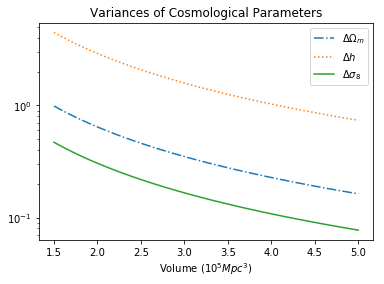

In [10]:
import matplotlib.pyplot as plt_Om
import matplotlib.pyplot as plt_h
import matplotlib.pyplot as plt_sig
import matplotlib.pyplot as plt_all

volume_range_plt = volume_range*10**-5

plt_all.plot(volume_range_plt, var_Om_np, label = '$\Delta \Omega_m$', linestyle = '-.')
plt_all.plot(volume_range_plt, var_h_np, label = '$\Delta h$', linestyle = ':')
plt_all.plot(volume_range_plt, var_sig_np, label = '$\Delta \sigma_8$')
plt_all.yscale('log')
plt_all.xlabel('Volume ($10^5 Mpc^3$)')
plt_all.legend()
plt_all.title('Variances of Cosmological Parameters')
plt_all.show()

In [11]:
# Choose the "true" parameters
omeg_true = 0.32
hubb_true = 0.67
sigm_true = 0.83

volume = 1.2e7 # Drew Newmann Carnegie

N_halos = n_halos*volume

vol_space = np.linspace(1e7,2e7,100)

HMF_true = HaloMassFunction(2, omega_m = omeg_true, omega_l = (1-omeg_true), hubble = hubb_true, sigma8 = sigm_true)

n_hal = integ.quad(HMF_true.dndm,3e13,13e13,epsrel=1e-2)[0] #Mass range 2.5-13*10^13 M_sun h^-1
N_hal = n_hal*vol_space
Nerr = (N_hal)**(-1/2)

In [12]:
def lnlike(theta,V,N_halos,Nerr):
    omeg,hubb,sigm = theta
    #print(theta)
    HMF_2 = HaloMassFunction(2, omega_m = omeg, omega_l = (1-omeg), hubble = hubb, sigma8 = sigm)
    n_model = integ.quad(HMF_2.dndm,3e13,13e13,epsrel=1e-2,epsabs=0)[0]
    model = n_model*V
    #inv_sigma2 = 1.0/(Nerr**2 + model**2*np.exp(2*lnf))
    inv_sigma2 = 1.0/(Nerr**2)
    return -0.5*(np.sum((N_halos-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    omeg,hubb,sigm = theta
    if 0.20 < omeg < 0.45 and 0.55 < hubb < 0.80 and 0.70 < sigm < 1.00:
        return 0.0
    return -np.inf

def lnprob(theta,V,N_halos,Nerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,V,N_halos,Nerr)

In [13]:
import scipy.optimize as op

nll = lambda *args: -lnlike(*args)
result = op.minimize(nll,[omeg_true,hubb_true,sigm_true],args=(vol_space,N_hal,Nerr),method='L-BFGS-B', bounds =((0.05,0.50),(0.50,0.90),(0.65,1.10)))
omeg_ml,hubb_ml,sigm_ml = result["x"]

In [14]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range (nwalkers)]

In [15]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (vol_space,N_hal,Nerr))

nsteps = 500

for i in range(20):
    sampler.run_mcmc(pos,nsteps)
    print("Steps completed =", (i+1)*nsteps)

/home/tommy/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


Steps completed = 500
Steps completed = 1000
Steps completed = 1500
Steps completed = 2000
Steps completed = 2500
Steps completed = 3000
Steps completed = 3500
Steps completed = 4000
Steps completed = 4500
Steps completed = 5000
Steps completed = 5500
Steps completed = 6000
Steps completed = 6500
Steps completed = 7000
Steps completed = 7500
Steps completed = 8000
Steps completed = 8500
Steps completed = 9000
Steps completed = 9500
Steps completed = 10000


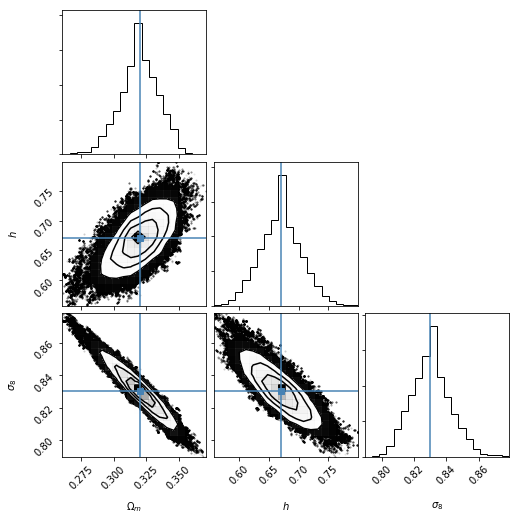

In [16]:
samples = sampler.chain[:,50:,:].reshape((-1,ndim))

import corner

fig = corner.corner(samples, labels=["$\Omega_m$", "$h$", "$\sigma_8$"],
                      truths=[omeg_true, hubb_true, sigm_true])

In [17]:
fig.savefig("param_contour_N10000.png")